In [110]:
from IPython.display import display, Math
import sympy as sp 


def afficheSimpy(expr) : 
    display(Math(sp.latex(expr)))
    return 

def rendreJoli(expr, u, x, t, dx, dt, ORDER_SERIES):
    """
    Retourne un latex isolant le puissances des deltaX et deltaT à l'affichage.
    """
    orders = range(0, ORDER_SERIES + 1) # Liste des ordres de dérivés temporelles que l'expression est suceptible de porter 
    dxs = [dx**n for n in orders] # Liste des puissances de deltaX 
    dts = [dt**n for n in orders] # Liste des puissances de deltaT 
    expr = expr.expand() # développe l'expression
    collected_dx = sp.collect(expr, dxs, evaluate=False) # cére un dictionnaire avec en clé les puissances de deltaX et en valeur les coeffs associés
    
    latex_lines = [] # liste des termes
    for dx_term, dx_expr in collected_dx.items(): # On itère sur les puissances de detaX (dx_term) et on accès au coefficient associés (dx_expr)
        collected_dt = sp.collect(dx_expr, dts, evaluate=False) # Crée un dictionnaire avec en clée les puissances de deltaT et en valeur les coeffs 
        for dt_term, coef in collected_dt.items():
            factor_parts = []
            if dt_term != 1:
                factor_parts.append(sp.latex(dt_term))
            if dx_term != 1:
                factor_parts.append(sp.latex(dx_term))
            factor_str = " ".join(factor_parts)
            
            if factor_str:
                latex_lines.append(f"{factor_str} \\left({sp.latex(coef)}\\right)")
            else:
                latex_lines.append(sp.latex(coef))
    
    return " + ".join(latex_lines)


def relation_fermeture(f:sp.Function,x:sp.Symbol,t:sp.Symbol,order:int,D:float) : 
    """
    Calcule la relation de fermeture permettant d'appliquer la procédure de Cauchy-Kovaleskaya pour l'équation de la chaleur
    f       : fonction à variables spatio-temporelle.
    x       : variable d'espace
    t       : variable temporelle
    order   : ordre de la dérivée temporelle à évaluer
    D       : coefficient de diffusion scalaire
    """
    return D**order * sp.diff(f(x,t),x,2*order)

def developpement_taylor_spatial(f:sp.Function,h:sp.Symbol,order:int,x:sp.Symbol,t:sp.Symbol):
    """
    Calcule le développement de tailor autour du point générique x au poit x+h. 
    f       : fonction à estimer.
    h       : écart par rapport à x.
    order   : ordre du DL. 
    x       : variable d'espace
    t       : varible en temps
    """
    return sum([
        h**k * sp.Rational(1,sp.factorial(k)) * sp.diff(f(x, t), x, k) 
        for k in range(order + 1)
    ]) 

def developpement_taylor_temps(f:sp.Function, h:sp.Symbol,order:int,x:sp.Symbol,t:sp.Symbol):
    """
    Calcule le développement de tailor autour du point générique t au poit t+h. 
    f       : fonction à estimer.
    h       : écart par rapport à t.
    order   : ordre du DL. 
    x       : variable d'espace
    t       : variable temporelle
    """
    return sum([
        h**k * sp.Rational(1,sp.factorial(k)) * sp.diff(f(x, t), t, k) 
        for k in range(order + 1)
    ]) 

def fourrier_voisin(f:sp.Function,h:sp.Symbol,xi:sp.Symbol,t:sp.Symbol) : 
    return f(xi,t) * sp.exp(-sp.I*xi*h)

DEBUG = 0
ORDER_SERIES = 4 # ordre des développements limités. 
DT_FROM_CFL = 0 # choisir si on défini dt à partir de la CFL ou si l'on défini la CFL à partir de dt. 
CAUCHY_KOVALESKAYA = 1
D = sp.Symbol("D", real=True) #Coefficient de diffusion
x, t = sp.symbols("x t", real=True)#Varaiables espace-temps
dx = sp.Symbol(r"\Delta x", real=True)#Pas de discrétisation spatial (niveau fin et grille uniforme)
u = sp.Function("u")#Fonction "régulière" vérifiant le schéma

u_fourrier =  sp.Function(r"\hat{u}")
xi = sp.Symbol(r"\xi",real = True)
if DT_FROM_CFL :
    CFL_DIFF = sp.Symbol(r"\lambda", real=True)
    dt = dx**2 * CFL_DIFF / D
else : 
    dt = sp.Symbol(r"\Delta t", real=True)
    CFL_DIFF = D * dt / dx**2
CFL_DIFF = D * dt / dx**2 
s_hat = sp.Symbol('$\hat s$', positive=True)
deltal = sp.Symbol(u'\\Delta l', positive=True)
fourrier_voisin(u_fourrier,-dx,xi,t)

\hat{u}(\xi, t)*exp(I*\Delta x*\xi)

In [111]:

def ordre_total_derivée(expr:sp.Expr):
    """
    Renvoie l'ordre de dérivation de l'expression entrée.
    Sert dans la procédure de Cauchy-Kovaleskaya.
    """
    return sum(o for _, o in expr.variable_count) if isinstance(expr, sp.Derivative) else 0

def apply_cauchy_kovaleskaya(expr,u,x,t,D,max_order):
    """
    applique Cauchy-Kovaleskaya à l'argument expr utilisant la relation de fermuture : dtu = D * dxxu
    expr        : expression à laquelle appliquer la procédure.
    u           : fonction
    x           : variable spatiale
    t           : variable temporelle
    D           : coefficient de diffusion
    max_order   : ordre de développement maximal
    """
    expr.expand() # Développe l'expression
    coeffs_dtn = sp.collect( # Crée un dictionnaire avec en clée les dérivées temporelle aux différents ordres qui apparaissent dans expr et en valeur les coefficients associés 
        expr ,
        [sp.diff(u(x, t), t,localOrder) for localOrder in range(2,max_order+1) ], # L'objectif est de remplacer les dérivées temporelles d'ordre 2 et plus.
        evaluate=False # Renvoie un dictionnaire et non seulement 
        )
    for (key,value) in coeffs_dtn.items(): # On itère sur les dérivées temporelles (key) en ayant accès a leurs coeffcients (value)
        ordre  = ordre_total_derivée(key)  # On récupère l'ordre de la dérivée temporelle sur laquelle on travaile
        if ordre == 0 : continue
        terme_temporel = key * value # On reconstruit le terme associé à la dérivée tempoelle
        terme_spatial = relation_fermeture(u,x,t,ordre , D) * value # On construit le terme associé faisant intervenir une dérivée spatiale à la place (c'est ici que l'on a besoin de l'ordre de la dérivée temporelle)
        expr = expr - terme_temporel + terme_spatial # On remplace le terme faisant intervenir la dérivée temporelle et on le remplace par celui mettant en jeu la dérivée spatiale
    return expr

def initP(stencil=1) :
    if stencil==1 : 
        P = sp.zeros(4,4)
        P[0,0] = sp.Rational(1,8)
        P[1,0] = sp.Rational(-1,8)
        P[2,1] = sp.Rational(1,8)
        P[3,1] = sp.Rational(-1,8)
        P[0,2] = sp.Rational(-1,8)
        P[1,2] = sp.Rational(1,8)
        P[2,3] = sp.Rational(-1,8)
        P[3,3] = sp.Rational(1,8)
        P[0,1] = 1
        P[1,1] = 1
        P[2,2] = 1
        P[3,2] = 1
        return P 
    else : raise NotImplementedError(f"not implemented s={stencil}")

def computeFlux(u,u_fourrier,x,t,dl,dx,cfl,ORDER_SERIES,stencil=1):
    dx_currentLevel = (2**(dl)) * dx # Calcul du deltaX courrant
    cfl_effective = cfl*(2**(-dl))
    Pdl = initP(stencil)**dl # Calcul de la matrice de passage au travers de deltaL couches
    coeffs = sp.Matrix([[
        sp.Rational(-1,2)*cfl_effective,
        +sp.Rational(3,2)*cfl_effective-1,
        -sp.Rational(3,2)*cfl_effective+1,
        sp.Rational(1,2)*cfl_effective,
        ]])
    
    coeffs_1 = sp.Matrix([[0,-1,1,0,]])
    coeffs_2 = sp.Matrix([[sp.Rational(-1,2),sp.Rational(+3,2),sp.Rational(-3,2),sp.Rational(1,2),]]) #* sp.Rational(1,2)
    
    Us_minusFlux_currentLevel = sp.Matrix([developpement_taylor_spatial(u,dx_currentLevel*delta,ORDER_SERIES,x,t) for delta in range(-2,2)])
    Us_plusFlux_currentLevel = sp.Matrix([developpement_taylor_spatial(u,dx_currentLevel*delta,ORDER_SERIES,x,t)  for delta in range(-1,3)])

    Us_minusFlux_currentLevel_fourrier = sp.Matrix([fourrier_voisin(u_fourrier,dx_currentLevel*delta,xi,t) for delta in range(-2,2)])
    Us_plusFlux_currentLevel_fourrier = sp.Matrix([fourrier_voisin(u_fourrier,dx_currentLevel*delta,xi,t)  for delta in range(-1,3)])
    # afficheSimpy(Us_plusFlux_currentLevel_fourrier)
    # afficheSimpy(Us_minusFlux_currentLevel_fourrier)
    # minusFlux = (coeffs * Pdl * Us_minusFlux_currentLevel)[0,0]
    # plusFlux  = (coeffs * Pdl *  Us_plusFlux_currentLevel)[0,0]
    # flux_variation_RK2_v1 = (cfl_effective * (plusFlux-minusFlux)).expand()
    minusFlux = ((cfl_effective*coeffs_1+cfl_effective**2*coeffs_2)*(Pdl * Us_minusFlux_currentLevel))[0,0]
    plusFlux  = ((cfl_effective*coeffs_1+cfl_effective**2*coeffs_2)*(Pdl *  Us_plusFlux_currentLevel))[0,0]

    minusFlux_Fourrier = ((cfl_effective*coeffs_1+cfl_effective**2*coeffs_2)*(Pdl * Us_minusFlux_currentLevel_fourrier))[0,0]
    plusFlux_Fourrier  = ((cfl_effective*coeffs_1+cfl_effective**2*coeffs_2)*(Pdl * Us_plusFlux_currentLevel_fourrier))[0,0]

    # afficheSimpy(minusFlux_Fourrier.expand())
    # afficheSimpy(plusFlux_Fourrier.expand())
    flux_variation_RK2 = (plusFlux-minusFlux).expand()
    flux_variation_RK2_fourrier = (plusFlux_Fourrier - minusFlux_Fourrier).expand()
    coefficient_amplification_RK2 = 1 + (flux_variation_RK2_fourrier / u_fourrier(xi,t))

    afficheSimpy(coefficient_amplification_RK2.expand().collect(cfl))
    coeffs_RK1 = sp.Matrix([[0,-1,1,0,]])
    minusFlux_RK1 = (coeffs_RK1 * Pdl * Us_minusFlux_currentLevel)[0,0]
    plusFlux_RK1 = (coeffs_RK1 * Pdl * Us_plusFlux_currentLevel)[0,0]
    flux_variation_RK1 = cfl_effective * (plusFlux_RK1-minusFlux_RK1)

    coeffs_Christian = sp.Matrix([[
        sp.Rational(-1,2)*(cfl-sp.Rational(1,6)) ,
        sp.Rational(3,2)*(cfl-sp.Rational(1,6))-1,
        1-sp.Rational(3,2)*(cfl-sp.Rational(1,6)),
        sp.Rational(1,2)*(cfl-sp.Rational(1,6)) ,
                        ]])
    minusFlux_Christian = (coeffs_Christian * Pdl * Us_minusFlux_currentLevel)[0,0]
    plusFlux_Christian = (coeffs_Christian * Pdl * Us_plusFlux_currentLevel)[0,0]
    flux_variation_Christian = cfl_effective * (plusFlux_Christian-minusFlux_Christian)

    return  flux_variation_RK2,flux_variation_RK1,flux_variation_Christian,coefficient_amplification_RK2


computeFlux(u,u_fourrier,x,t,deltal,dx,CFL_DIFF,ORDER_SERIES,stencil=1)


<IPython.core.display.Math object>

(-2**(2*\Delta l)*D*\Delta l*\Delta t*\Delta x**2*Derivative(u(x, t), (x, 4))/4 + 2**(2*\Delta l)*D*\Delta t*\Delta x**2*Derivative(u(x, t), (x, 4))/12 + 2**\Delta l*D**2*\Delta t**2*Derivative(u(x, t), (x, 4))/2 + D*\Delta t*Derivative(u(x, t), (x, 2)),
 D*\Delta t*(2**(1 - \Delta l)*\Delta l*(2**(4*\Delta l)*\Delta x**4*Derivative(u(x, t), (x, 4))/24 - 2**(3*\Delta l)*\Delta x**3*Derivative(u(x, t), (x, 3))/6 + 2**(2*\Delta l)*\Delta x**2*Derivative(u(x, t), (x, 2))/2 - 2**\Delta l*\Delta x*Derivative(u(x, t), x) + u(x, t))/8 + 2**(1 - \Delta l)*\Delta l*(2**(4*\Delta l)*\Delta x**4*Derivative(u(x, t), (x, 4))/24 + 2**(3*\Delta l)*\Delta x**3*Derivative(u(x, t), (x, 3))/6 + 2**(2*\Delta l)*\Delta x**2*Derivative(u(x, t), (x, 2))/2 + 2**\Delta l*\Delta x*Derivative(u(x, t), x) + u(x, t))/8 - 2**(1 - \Delta l)*\Delta l*(2*2**(4*\Delta l)*\Delta x**4*Derivative(u(x, t), (x, 4))/3 - 4*2**(3*\Delta l)*\Delta x**3*Derivative(u(x, t), (x, 3))/3 + 2*2**(2*\Delta l)*\Delta x**2*Derivative(u(x

In [112]:

def computeEqModif(u,u_fourrier,x,t,dl,dx,dt,D,cfl,ORDER_SERIES,CAUCHY_KOVALESKAYA=True,stencil=1,DEBUG=0) : 
    flux_total_RK2,flux_total_RK1,flux_total_Christian,coeff_amplification_RK2 = computeFlux(u,u_fourrier,x,t,dl,dx,cfl,ORDER_SERIES,stencil=1) 
    rhs = (1/dt*flux_total_RK2).expand() #RK2
    rhs_RK1 = (1/dt*flux_total_RK1).expand() #RK1
    rhs_Christian = (1/dt*flux_total_Christian).expand() #RK2 - Modifiée Christian 
    lhs = (1/dt * (developpement_taylor_temps(u,dt,ORDER_SERIES,x,t) - u(x,t))).expand() # Approximation de la dérivée temporelle : (u^n+1 - u^n)/dt
    rhs = rhs - (lhs - sp.diff(u(x,t),t,1)) #RK2
    rhs_RK1 = rhs_RK1-(lhs - sp.diff(u(x,t),t,1)) #RK1
    rhs_Christian = rhs_Christian-(lhs - sp.diff(u(x,t),t,1)) #RK2 - Modifiée Christian 
    lhs = sp.diff(u(x,t),t,1)
    if CAUCHY_KOVALESKAYA : 
        rhs=apply_cauchy_kovaleskaya(rhs,u,x,t,D,ORDER_SERIES) #RK2
        rhs_RK1=apply_cauchy_kovaleskaya(rhs_RK1,u,x,t,D,ORDER_SERIES)  #RK1
        rhs_Christian=apply_cauchy_kovaleskaya(rhs_Christian,u,x,t,D,ORDER_SERIES)  #RK2 - Modifiée Christian 
    tex =sp.latex(lhs) + "=" + (rendreJoli(rhs,u,x,t,dx,dt,4)) #RK2
    
    tex_RK1 =sp.latex(lhs) + "=" + sp.latex(rhs_RK1) #RK2
    tex_Christian = sp.latex(lhs) + "=" + sp.latex(rhs_Christian) #RK2 - Modifiée Christian 
    return {"RK2":(lhs,rhs,tex),"RK1":(lhs,rhs_RK1,tex_RK1),"Christian" : (lhs,rhs_Christian,tex_Christian)}  , coeff_amplification_RK2# Dictionnaire



DEBUG = 0
ORDER_SERIES = 4 # ordre des développements limités. 
DT_FROM_CFL = 1 # choisir si on défini dt à partir de la CFL ou si l'on défini la CFL à partir de dt. 
CAUCHY_KOVALESKAYA = 1
D = sp.Symbol("D", real=True) #Coefficient de diffusion
x, t = sp.symbols("x t", real=True)#Varaiables espace-temps
dx = sp.Symbol(r"\Delta x", real=True)#Pas de discrétisation spatial (niveau fin et grille uniforme)
u = sp.Function("u")#Fonction "régulière" vérifiant le schéma

u_fourrier =  sp.Function(r"\hat{u}")
xi = sp.Symbol(r"\xi",real = True)
if DT_FROM_CFL :
    CFL_DIFF = sp.Symbol(r"\lambda", real=True)
    dt = dx**2 * CFL_DIFF / D
else : 
    dt = sp.Symbol(r"\Delta t", real=True)
    CFL_DIFF = D * dt / dx**2
CFL_DIFF = D * dt / dx**2 
s_hat = sp.Symbol('$\hat s$', positive=True)
deltal = sp.Symbol(u'\\Delta l', positive=True)

u_xplus1 = developpement_taylor_spatial(u,+dx,ORDER_SERIES,x,t) # développement de Taylor en espace en x+dx
u_xplus2 = developpement_taylor_spatial(u,+2*dx,ORDER_SERIES,x,t) # développement de Taylor en espace en x+2dx
u_xmoins1 = developpement_taylor_spatial(u,-dx,ORDER_SERIES,x,t) # développement de Taylor en espace en x-dx
u_xmoins2 = developpement_taylor_spatial(u,-2*dx,ORDER_SERIES,x,t) # développement de Taylor en espace en x-2dx
reste_serie_en_temps =((developpement_taylor_temps(u,dt,ORDER_SERIES,x,t) - u(x,t))/dt - sp.diff(u(x,t),t)).expand() # Erreur résiduelle lorsque l'on approxime du/dt = (u^t+1 - u^t)/dt
derivee_temporelle = sp.diff(u(x, t), t) # dérivée temporelle d'ordre 1


# Méthode des lignes RK1
print("Eq modifée temps-espace RKE1")
flux_total_sans_AMR_RK1 = (CFL_DIFF * 
                        (u_xplus1 - 2*u(x,t) + u_xmoins1)).expand()
u_t_RK1 = - reste_serie_en_temps + 1/dt*flux_total_sans_AMR_RK1
u_t_RK1 = u_t_RK1.expand()
u_t_RK1 = apply_cauchy_kovaleskaya(u_t_RK1,u,x,t,D,ORDER_SERIES)
eq_sans_AMR_RK1 = f"{sp.latex(derivee_temporelle)} = {sp.latex(u_t_RK1)}"
display(Math(eq_sans_AMR_RK1))

# Méthode des lignes RK2
print("Eq modifée temps-espace RKE2")
flux_total_sans_AMR = CFL_DIFF*(
                    (u_xplus1 - 2*u(x,t) + u_xmoins1) 
                       +sp.Rational(1,2) * CFL_DIFF*(u_xplus2 - 4*u_xplus1 + 6*u(x,t) - 4*u_xmoins1 + u_xmoins2)
                    ).expand()
var_flux_RK2_sans_AMR_fourrier =((1/ u_fourrier(xi,t))*(CFL_DIFF * (
                                    + fourrier_voisin(u_fourrier , dx ,xi,t)
                                    - 2*u_fourrier(xi,t)
                                    + fourrier_voisin(u_fourrier,-dx,xi,t)
                                    )+ CFL_DIFF**2 * (
                                    + sp.Rational(1,2) * fourrier_voisin(u_fourrier , 2*dx ,xi,t)
                                    -2 * fourrier_voisin(u_fourrier , dx ,xi,t)
                                    +3 * u_fourrier(xi,t)
                                    -2 * fourrier_voisin(u_fourrier , -dx ,xi,t)
                                    + sp.Rational(1,2) * fourrier_voisin(u_fourrier , -2*dx ,xi,t)
                        ))).expand()
coeff_ampli_sans_AMR = 1 + var_flux_RK2_sans_AMR_fourrier
u_t = - reste_serie_en_temps +(1/dt) * flux_total_sans_AMR # équation équivalente brute. 
u_t = u_t.expand()
u_t = apply_cauchy_kovaleskaya(u_t,u,x,t,D,ORDER_SERIES)
second_membre = rendreJoli(u_t,u,x,t,dx,dt,ORDER_SERIES)
eq_sans_AMR_Latex = f"{sp.latex(derivee_temporelle)} = {sp.latex(u_t)}"
display(Math(eq_sans_AMR_Latex))

### Christian 
print("Eq modifée temps-espace Version Christian")
flux_total_sans_AMR_Chr = CFL_DIFF*((u_xplus1 - 2*u(x,t) + u_xmoins1)
                        +sp.Rational(1,2)*(CFL_DIFF - sp.Rational(1,6))* (u_xplus2 - 4*u_xplus1 + 6*u(x,t) - 4*u_xmoins1 + u_xmoins2)).expand()
u_t_Chr = - reste_serie_en_temps + 1/dt*flux_total_sans_AMR_Chr
u_t_Chr = u_t_Chr.expand()
u_t_Chr = apply_cauchy_kovaleskaya(u_t_Chr,u,x,t,D,ORDER_SERIES)
eq_sans_AMR_Chr = f"{sp.latex(derivee_temporelle)} = {sp.latex(u_t_Chr)}"
display(Math(eq_sans_AMR_Chr))



dictionnary,coefficient_amplification             = computeEqModif(u,u_fourrier,x,t,deltal,dx,dt,D,CFL_DIFF,ORDER_SERIES,CAUCHY_KOVALESKAYA=CAUCHY_KOVALESKAYA,stencil=1,DEBUG=DEBUG)
# print("--------------------------------------  EQUA. MODIFIEES [RK1] --------------------------------------")
# _,_,texRK1    = dictionnary["RK1"]
# print("\n       *   SANS Multi-Résolution   ❌\n")
# display(Math(eq_sans_AMR_Latex))
# print("\n       *  AVEC Multi-Résolution    ✅")
# display(Math(texRK1))

print("--------------------------------------  EQUA. MODIFIEES [RK2] --------------------------------------")
_,_,texRK2             = dictionnary["RK2"]
print("\n       *   SANS Multi-Résolution   ❌\n")
print(eq_sans_AMR_Latex)
display(Math(eq_sans_AMR_Latex))
print("\n       *  AVEC Multi-Résolution   ✅")
display(Math(texRK2))

# print("--------------------------------------  EQUA. MODIFIEES [RK2 - Christian] --------------------------------------")
# _,_,texChristian             = dictionnary["Christian"]
# print("\n       *   SANS Multi-Résolution   ❌\n")
# display(Math(eq_sans_AMR_Latex))
# print("\n       *  AVEC Multi-Résolution   ✅")
# display(Math(texChristian))


Eq modifée temps-espace RKE1


<IPython.core.display.Math object>

Eq modifée temps-espace RKE2


<IPython.core.display.Math object>

Eq modifée temps-espace Version Christian


<IPython.core.display.Math object>

<IPython.core.display.Math object>

--------------------------------------  EQUA. MODIFIEES [RK2] --------------------------------------

       *   SANS Multi-Résolution   ❌

\frac{\partial}{\partial t} u{\left(x,t \right)} = - \frac{D \Delta x^{6} \lambda^{3} \frac{\partial^{8}}{\partial x^{8}} u{\left(x,t \right)}}{24} - \frac{D \Delta x^{4} \lambda^{2} \frac{\partial^{6}}{\partial x^{6}} u{\left(x,t \right)}}{6} + \frac{D \Delta x^{2} \frac{\partial^{4}}{\partial x^{4}} u{\left(x,t \right)}}{12} + D \frac{\partial^{2}}{\partial x^{2}} u{\left(x,t \right)}


<IPython.core.display.Math object>


       *  AVEC Multi-Résolution   ✅


<IPython.core.display.Math object>

In [113]:
import numpy as np
import matplotlib.pyplot as plt 
coefficient_amplification = coefficient_amplification.expand()
print(coefficient_amplification)
afficheSimpy(coefficient_amplification)
print("Sans AMR")
coeff_ampli_sans_AMR=coeff_ampli_sans_AMR.rewrite(sp.cos).collect(CFL_DIFF)
print(coeff_ampli_sans_AMR)
afficheSimpy(coeff_ampli_sans_AMR)


1 - \Delta l*\lambda*exp(2*2**\Delta l*I*\Delta x*\xi)/(4*2**(2*\Delta l)) + \Delta l*\lambda*exp(2**\Delta l*I*\Delta x*\xi)/2**(2*\Delta l) - 3*\Delta l*\lambda/(2*2**(2*\Delta l)) + \Delta l*\lambda*exp(-2**\Delta l*I*\Delta x*\xi)/2**(2*\Delta l) - \Delta l*\lambda*exp(-2*2**\Delta l*I*\Delta x*\xi)/(4*2**(2*\Delta l)) + \lambda*exp(2**\Delta l*I*\Delta x*\xi)/2**(2*\Delta l) - 2*\lambda/2**(2*\Delta l) + \lambda*exp(-2**\Delta l*I*\Delta x*\xi)/2**(2*\Delta l) + \lambda**2*exp(2*2**\Delta l*I*\Delta x*\xi)/(2*2**(3*\Delta l)) - 2*\lambda**2*exp(2**\Delta l*I*\Delta x*\xi)/2**(3*\Delta l) + 3*\lambda**2/2**(3*\Delta l) - 2*\lambda**2*exp(-2**\Delta l*I*\Delta x*\xi)/2**(3*\Delta l) + \lambda**2*exp(-2*2**\Delta l*I*\Delta x*\xi)/(2*2**(3*\Delta l))


<IPython.core.display.Math object>

Sans AMR
\lambda**2*(-4*cos(\Delta x*\xi) + cos(2*\Delta x*\xi) + 3) + \lambda*(2*cos(\Delta x*\xi) - 2) + 1


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

[0.00000000e+00 3.21731261e-02 6.43462522e-02 ... 3.21634741e+02
 3.21666915e+02 3.21699088e+02]


/var/folders/rg/g39v1pbj2wb5lg57tl9k_ws80000gq/T/ipykernel_22841/3287034186.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("magma", len(cfl_list))


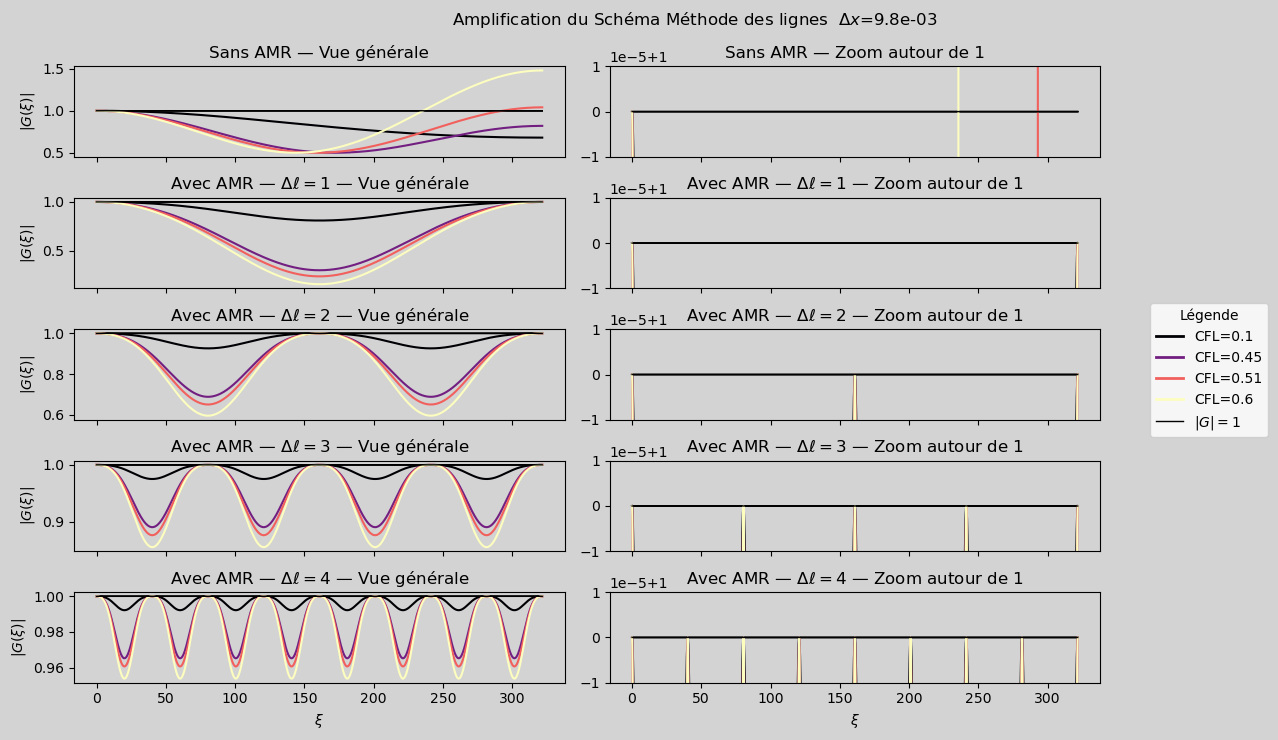

In [ ]:

user_delta_l = 2
user_cfl = 0.6
L = 40 
LEVEL = 12
N_POINTS = 2**12 
user_dx = L/N_POINTS
local_coeff_ampli_sans_AMR = coeff_ampli_sans_AMR.subs([(CFL_DIFF,user_cfl),(dx,user_dx)])
local_coefficient_amplification = coefficient_amplification.subs([(deltal , user_delta_l) , (CFL_DIFF , user_cfl) , (dx , user_dx)]).simplify()
afficheSimpy(local_coefficient_amplification)
afficheSimpy(sp.simplify(sp.expand_complex(local_coeff_ampli_sans_AMR.rewrite(sp.cos))))
# Création de la fonction numérique numpy-compatible
G = sp.lambdify(xi, local_coefficient_amplification, "numpy")
G_simple = sp.lambdify(xi , local_coeff_ampli_sans_AMR,"numpy" )

xis = np.linspace(0,np.pi/user_dx,10000)
print(xis)
# Valeurs numériques
import matplotlib.cm as cm
from matplotlib.lines import Line2D

# --- paramètres ---
cfl_list = [0.1, 0.45, 0.51, 0.6]
dl_list  = [1, 2, 3, 4]
cmap = cm.get_cmap("magma", len(cfl_list))

# Abscisses (si non défini plus haut)
try:
    xis
except NameError:
    xis = np.linspace(0.0, np.pi, 2000)

# --- figure : (nombre_dl + 1) x 2 ---
nrows = len(dl_list) + 1
ncols = 2
fig_h = 1.5 * nrows
fig, axs = plt.subplots(nrows, ncols, figsize=(14, fig_h), sharex=True, sharey=False)
fig.suptitle(rf"Amplification du Schéma Méthode des lignes  $\Delta x$={user_dx:.1e}")

# Fond lightgray
fig.patch.set_facecolor("lightgray")
for r in range(nrows):
    for c in range(ncols):
        axs[r, c].set_facecolor("lightgray")

# ----------------- Ligne 0 : Sans AMR -----------------
for i, cfl in enumerate(cfl_list):
    color = cmap(i)
    local_coeff_ampli_sans_AMR = coeff_ampli_sans_AMR.subs([(CFL_DIFF, cfl), (dx, user_dx)])
    G_simple = sp.lambdify(xi, local_coeff_ampli_sans_AMR, "numpy")
    amp_simple = G_simple(xis)

    # Col 0 : vue générale
    ax = axs[0, 0]
    ax.set_title("Sans AMR — Vue générale")
    ax.plot(xis, np.abs(amp_simple), color=color, linestyle='-')
    ax.plot(xis, np.ones_like(xis), color='black', linewidth=1)  # |G|=1

    # Col 1 : zoom autour de 1
    ax = axs[0, 1]
    ax.set_title("Sans AMR — Zoom autour de 1")
    ax.set_ylim([1 - 1e-5, 1 + 1e-5])
    ax.plot(xis, np.abs(amp_simple), color=color, linestyle='-')
    ax.plot(xis, np.ones_like(xis), color='black', linewidth=1)  # |G|=1

# ----------------- Lignes 1.. : Avec AMR (Δl = 1..4) -----------------
for r, user_delta_l in enumerate(dl_list, start=1):
    for i, cfl in enumerate(cfl_list):
        color = cmap(i)

        local_coefficient_amplification = coefficient_amplification.subs([
            (deltal, user_delta_l), (CFL_DIFF, cfl), (dx, user_dx)
        ]).simplify()
        G = sp.lambdify(xi, local_coefficient_amplification, "numpy")
        amp = G(xis)

        # Col 0 : vue générale
        ax = axs[r, 0]
        # ax.set_title(fr"Avec AMR — $\Delta \ell={user_delta_l}$ — Vue générale")
        ax.plot(xis, np.abs(amp), color=color, linestyle='-')
        ax.plot(xis, np.ones_like(xis), color='black', linewidth=1)
        axs[r, 0].set_ylabel(fr"$|G(\xi)| - \Delta l = {user_delta_l}$")

        # Col 1 : zoom autour de 1
        ax = axs[r, 1]
        # ax.set_title(fr"Avec AMR — $\Delta \ell={user_delta_l}$ — Zoom autour de 1")
        ax.set_ylim([1 - 1e-5, 1 + 1e-5])
        ax.plot(xis, np.abs(amp), color=color, linestyle='-')
        ax.plot(xis, np.ones_like(xis), color='black', linewidth=1)
        axs[r, 0].set_ylabel(fr"$|G(\xi)| - \Delta l = {user_delta_l}$")

# Labels d’axes

axs[-1, 0].set_xlabel(r"$\xi$")
axs[-1, 1].set_xlabel(r"$\xi$")

# Légende partagée à droite : couleurs = CFL, + ref |G|=1
legend_cfl = [Line2D([0], [0], color=cmap(i), lw=2, label=f"CFL={c}")
              for i, c in enumerate(cfl_list)]
legend_ref = [Line2D([0], [0], color='k', lw=1, label=r"$|G|=1$")]

fig.legend(handles=(legend_cfl + legend_ref),
           loc='center left', bbox_to_anchor=(0.82, 0.5),
           frameon=True, title="Légende")

# Marges (plus d'espace vertical) + place pour la légende
fig.tight_layout(rect=[0.0, 0.0, 0.80, 1.0], h_pad=0.8)
plt.show()


[1.+0.j 1.+0.j] [0.9999999+0.j 0.9999999+0.j]
[1.+0.j 1.+0.j] [0.9999999+0.j 0.9999999+0.j]
[1.+0.j 1.+0.j] [0.9999999+0.j 0.9999999+0.j]


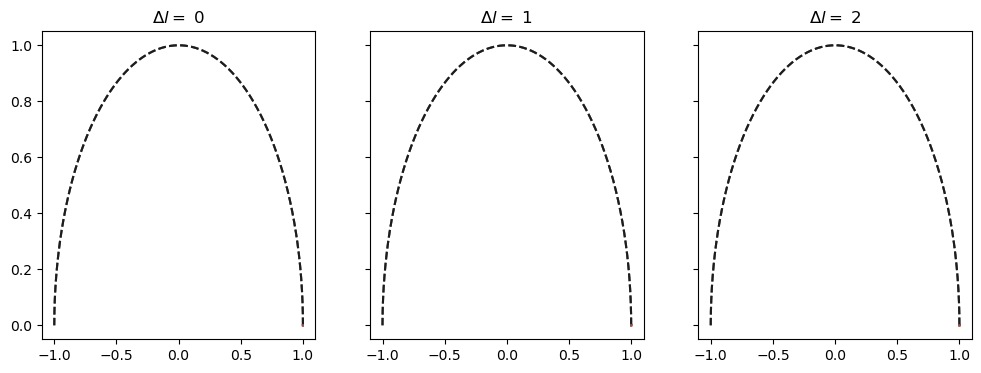

In [115]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# --- Hypothèse : ces symboles et l'expression existent déjà dans ton code ---
# xi, CFL_DIFF, deltal, dx = sp.symbols("xi CFL_DIFF deltal dx")  # décommente si besoin
# coefficient_amplification = ...  # construit plus haut
coefficient_amplification = coefficient_amplification.expand()

# --- Paramètres ---
dl_list   = [0, 1, 2, 3]                 # plusieurs Δl
cfl_list  = [0.1 , 0.4 ,0.55, 0.7 , 0.9 ,1]  # 6 CFL (adapte si besoin)
user_dx   = 1e-4
xis       = np.linspace(0 ,np.pi, 2000)   # domaine de Nyquist
eps_stab  = 1e-12                           # marge numérique pour |G|<1

# --- Lambdify multivariable (vectorisé NumPy) ---
G_np = sp.lambdify((xi, CFL_DIFF, deltal, dx), coefficient_amplification, "numpy")


# --- Figure : 2x3 ---
cercle_ref = np.exp(1j * xis)
fig,axs = plt.subplots(1,3,figsize=(12,4),sharex=True,sharey=True)
for ax,dl in zip(axs,dl_list) : 
    for cfl in cfl_list : 
        ax.plot(np.real(cercle_ref),np.imag(cercle_ref),color = 'k',linestyle = 'dashed',alpha = .3)
        vals = G_np(xis, cfl, int(dl), float(user_dx))
        ax.plot(np.real(vals),np.imag(vals))
        ax.set_title(fr"$\Delta l =$ {dl}")
        
    print(vals[:2] , vals[-2:])




(1000, 2000)
(1000, 2000)
(1000, 2000)
(1000, 2000)


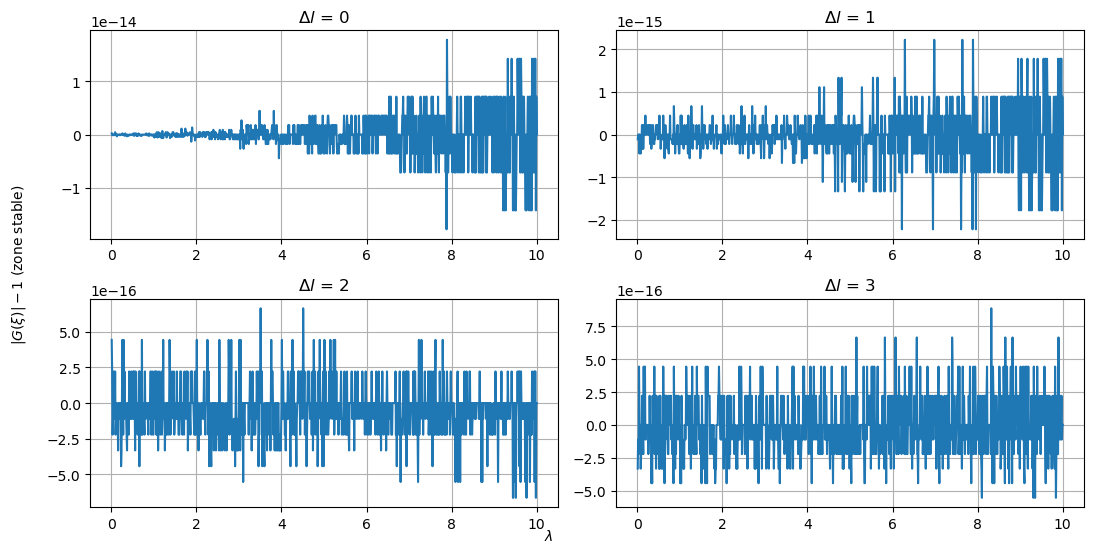

In [116]:

cfls = np.linspace(0.01 , 10, 1000)
xis_grid , cfls_grid = np.meshgrid(xis,cfls)
fig, axes = plt.subplots(2, 2, figsize=(11, 6), sharex=False, sharey=False)
axes = axes.ravel()

for ax, dl in zip(axes, dl_list):

    # Évaluation : xi est un vecteur, CFL/dl/dx scalaires
    vals = G_np(xis_grid, cfls_grid, int(dl), float(user_dx))
    print(vals.shape)
    amp  = np.abs(vals).max(axis = 1)
    ax.plot(cfls, amp - 1)

    ax.set_title(rf"$\Delta l$ = {dl:g}")
    ax.grid(True)

# Mise en forme
for ax in axes:
    # ax.set_xlim(0, np.pi)
    # ax.set_ylim(0, 1.0)  # on ne garde que la zone stable
    # ax.xaxis.set_major_formatter(mticker.ScalarFormatter(useOffset=False))
    ax.ticklabel_format(style="plain", axis="x")
    # ax.legend(title="Niveau MR", loc="lower left", fontsize=8)

fig.text(0.5, 0.04, r"$\lambda$", ha="center")
fig.text(0.01, 0.5, r"$|G(\xi)| - 1$ (zone stable)", va="center", rotation="vertical")


plt.tight_layout(rect=[0.03, 0.03, 1, 0.95])
plt.show()



/var/folders/rg/g39v1pbj2wb5lg57tl9k_ws80000gq/T/ipykernel_22841/4201772843.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title="Niveau MR", loc="lower left", fontsize=8)


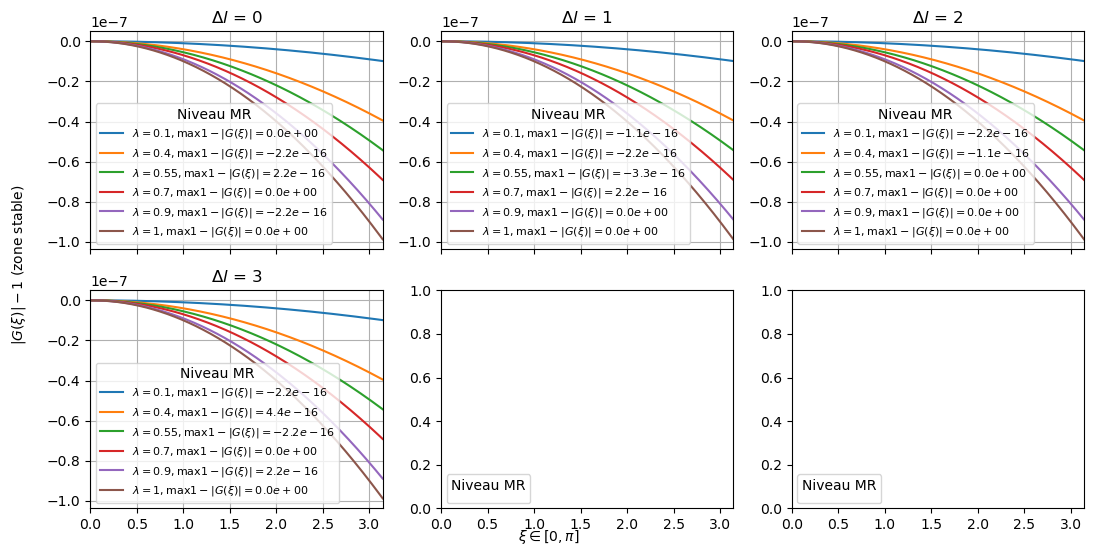

In [117]:


# --- Figure : 2x3 ---
fig, axes = plt.subplots(2, 3, figsize=(11, 6), sharex=True, sharey=False)
axes = axes.ravel()

for ax, dl in zip(axes, dl_list):
    for cfl in cfl_list:
        # Évaluation : xi est un vecteur, CFL/dl/dx scalaires
        vals = G_np(xis, float(cfl), int(dl), float(user_dx))
        amp  = np.abs(vals)
        # Masque stabilité stricte |G|<1 (avec marge)
        ax.plot(xis, amp-1, label=rf"$\lambda={cfl},\max 1 - |G(\xi)|={ (amp.max() - 1):.1e}$")

    ax.set_title(rf"$\Delta l$ = {dl:g}")
    ax.grid(True)

# Mise en forme
for ax in axes:
    ax.set_xlim(0, np.pi)
    # ax.set_ylim(0, 1.0)  # on ne garde que la zone stable
    # ax.xaxis.set_major_formatter(mticker.ScalarFormatter(useOffset=False))
    ax.ticklabel_format(style="plain", axis="x")
    ax.legend(title="Niveau MR", loc="lower left", fontsize=8)

fig.text(0.5, 0.04, r"$\xi \in [0,\pi]$", ha="center")
fig.text(0.01, 0.5, r"$|G(\xi)| - 1$ (zone stable)", va="center", rotation="vertical")


plt.tight_layout(rect=[0.03, 0.03, 1, 0.95])
plt.show()



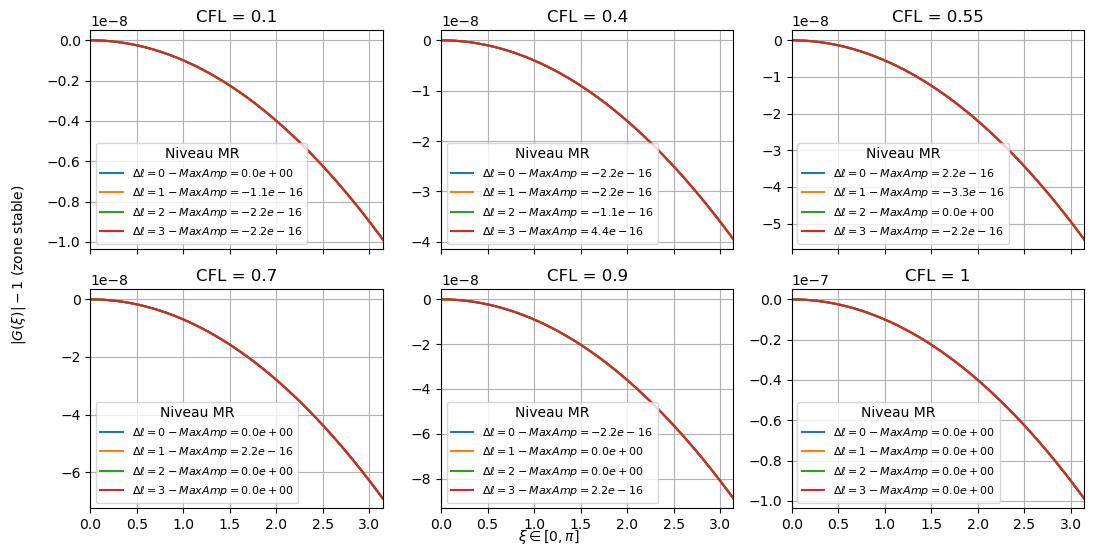

In [118]:
fig, axes = plt.subplots(2, 3, figsize=(11, 6), sharex=True, sharey=False)
axes = axes.ravel()

for ax, cfl in zip(axes, cfl_list):
    for dl in dl_list:
        # Évaluation : xi est un vecteur, CFL/dl/dx scalaires
        vals = G_np(xis, float(cfl), int(dl), float(user_dx))
        amp  = np.abs(vals)
        # Masque stabilité stricte |G|<1 (avec marge)
        ax.plot(xis, amp-1, label=f"$\Delta \ell={dl} - Max Amp = { (amp.max() - 1):.1e}$")

    ax.set_title(fr"CFL = {cfl:g}")
    ax.grid(True)

# Mise en forme
for ax in axes:
    ax.set_xlim(0, np.pi)
    # ax.set_ylim(0, 1.0)  # on ne garde que la zone stable
    # ax.xaxis.set_major_formatter(mticker.ScalarFormatter(useOffset=False))
    ax.ticklabel_format(style="plain", axis="x")
    ax.legend(title="Niveau MR", loc="lower left", fontsize=8)

fig.text(0.5, 0.04, r"$\xi \in [0,\pi]$", ha="center")
fig.text(0.01, 0.5, r"$|G(\xi)| - 1$ (zone stable)", va="center", rotation="vertical")


plt.tight_layout(rect=[0.03, 0.03, 1, 0.95])
plt.show()
